# Comparing plot for poster

Everything in this notebook is Cell 5 protocol 3. 

- For the data, I used the splines with weithgs
- For the synt data, the data is stochastic gatting plus normal noise. And I'll do the residuals from the ODE solution


In [1]:
# Libraries

import matplotlib.pyplot as plt
import numpy as np
import myokit
import myokit.lib.markov
from scipy.interpolate import interp1d

from scipy.optimize import minimize, minimize_scalar#, curve_fit
import cma
from sklearn.linear_model import LinearRegression

In [2]:
def expo_spline(times, deltat, params, expo_4):
    # three_expo = flag to calculate 2 or 3 exponentials. Default == False. If true, we'll be fitting sum of 3 expo
    expo_splines = params[0] + params[1]*np.exp(-(times-deltat)/params[2])+params[3]*np.exp(-(times-deltat)/params[4])
    if expo_4:
        expo_splines = expo_splines + params[5]*np.exp(-(times-deltat)/params[6]) + params[7]*np.exp(-(times-deltat)/params[8])
    return expo_splines

# Meta parameters

In [4]:
times_to_skip = 50 
NumExpo_flag = True # We will use 4 exponentials

seed_m = 1
np.random.seed(seed_m)

N_synth = 70000
FileName_synth = 'protocol3_cell5_sim_pars_M_M1_N_upper_' + str(N_synth)
FileName_real_splines = 'protocol3_cell5_splines_params_largerCurrents_weights.npy'


In [5]:
# Load the data, ode fit, stochastic fit and splines

print('Loading real data..')
pr3_time, pr3_voltage, pr3_current = np.loadtxt('/Users/pmzah/OneDrive - The University of Nottingham/Postdoc/cardiacNoiseData/KyliePR3cellall.txt', delimiter=',',skiprows=1, usecols=(0,1,6), unpack=True)

print('Loading synth data with noise ...')
pr3_synth_current = np.load(FileName_synth + '_I_inter_withNoise_epsilon25e06.npy')

print('Loading protocol and model to myokit...')
# Load model
model = myokit.load_model('resources/beattie-2017-ikr-markov-M-M3.mmt')
# Load a protocols
protocol_3 = myokit.load_protocol('resources/pr3-steady-activation.mmt')
#protocol_5 = myokit.load_protocol('resources/pr5-deactivation.mmt')

# Create a parametrisable Hodgkin-Huxley model
parameters = [
    'ikr.p1', 
    'ikr.p2', 
    'ikr.p3', 
    'ikr.p4', 
    'ikr.p5', 
    'ikr.p6', 
    'ikr.p7', 
    'ikr.p8', 
    'ikr.p9',
]
markov_model = myokit.lib.markov.LinearModel.from_component(model.get('ikr'), parameters=parameters)
# Create an analytical simulation 
markov_sim_pr3 = myokit.lib.markov.AnalyticalSimulation(markov_model, protocol_3)
# Log times will be equal to the times from the data

print('Creating ODE simulation')
hh_log_pr3 = markov_sim_pr3.run(pr3_time[-1] + 0.1, log_times=pr3_time)

pr3_I_ode = hh_log_pr3['ikr.IKr']



Loading real data..
Loading synth data with noise ...
Loading protocol and model to myokit...
Creating ODE simulation


In [13]:
# Define the steps of the protocol
pr3_Vtimes = (np.array(protocol_3.log_for_interval(0,pr3_time[-1] + 0.1)['time'])*10)
pr3_Vtimes = pr3_Vtimes.astype(np.int32)

pr3_current_constV = {}
pr3_current_constV_without_first5ms = {}
pr3_time_constV_without_first5ms = {}
pr3_synth_current_constV = {}
pr3_synth_current_constV_without_first5ms ={}
pr3_I_ode_constV ={}
pr3_I_ode_constV_without_first5ms ={}


for i in range(len(pr3_Vtimes)-1):
    pr3_current_constV[i]= pr3_current[pr3_Vtimes[i]:(pr3_Vtimes[i+1]-1)]
    pr3_current_constV_without_first5ms[i] = pr3_current[pr3_Vtimes[i] + times_to_skip:(pr3_Vtimes[i+1]-1)]
    pr3_time_constV_without_first5ms[i] = pr3_time[pr3_Vtimes[i] + times_to_skip:(pr3_Vtimes[i+1]-1)]
    pr3_synth_current_constV[i] = pr3_synth_current[pr3_Vtimes[i] :(pr3_Vtimes[i+1]-1)]
    pr3_synth_current_constV_without_first5ms[i] = pr3_synth_current[pr3_Vtimes[i] + times_to_skip:(pr3_Vtimes[i+1]-1)]
    pr3_I_ode_constV[i] = pr3_I_ode[pr3_Vtimes[i] :(pr3_Vtimes[i+1]-1)]
    pr3_I_ode_constV_without_first5ms[i] = pr3_I_ode[pr3_Vtimes[i] + times_to_skip : (pr3_Vtimes[i+1]-1)]
print(len(pr3_current_constV))

# Voltages
pr3_voltage_constV = pr3_voltage[pr3_Vtimes[:-1]]
pr3_unique_Vs, pr3_unique_Vs_1stUindex, pr3_unique_Vs_index= np.unique(pr3_voltage_constV, return_index = True, return_inverse = True)

# Colors & labels long
pr3_unique_Vs_colors = ['#a6cee3','#1f78b4','#b2df8a','#33a02c','#fb9a99','#e31a1c','#fdbf6f','#ff7f00','#cab2d6']
pr3_voltage_constV_colors = []
pr3_voltage_constV_labels_full = []
for i in range(len(pr3_unique_Vs_index)):
    pr3_voltage_constV_colors.append(pr3_unique_Vs_colors[pr3_unique_Vs_index[i]])
    pr3_voltage_constV_labels_full.append('V ='+str(pr3_unique_Vs[pr3_unique_Vs_index[i]]))

# Labels simple
pr3_voltage_constV_labels_simple = np.repeat('_nolegend_', len(pr3_unique_Vs_index))
for i in range(len(pr3_unique_Vs_1stUindex)):
    pr3_voltage_constV_labels_simple[pr3_unique_Vs_1stUindex[i]] = 'V ='+str(pr3_unique_Vs[i])

42


In [14]:
print('Diving by currents >=-40')
index_largerCurrents = np.nonzero(pr3_voltage_constV[:-1]>=-40)

index_largerCurrents = index_largerCurrents[0]


times_largerCurrents = [None] * len(index_largerCurrents)
deltat_largerCurrents = np.zeros(len(index_largerCurrents))
currents_largerCurrents = [None] * len(index_largerCurrents)
synth_currents_largerCurrents = [None] * len(index_largerCurrents)
splines_largerCurrents = [None] * len(index_largerCurrents)
splines_residuals2_largerCurrents = [None] * len(index_largerCurrents)
ode_largerCurrents = [None] * len(index_largerCurrents)
ode_residuals2_largerCurrents = [None] * len(index_largerCurrents)


# Separate times and currents:
for index_i in range(len(index_largerCurrents)):
    i=index_largerCurrents[index_i]
    times_largerCurrents[index_i] = pr3_time_constV_without_first5ms[i]
    deltat_largerCurrents[index_i] =  times_largerCurrents[index_i][0]
    currents_largerCurrents[index_i] = pr3_current_constV_without_first5ms[i]
    synth_currents_largerCurrents[index_i] = pr3_synth_current_constV_without_first5ms[i]
    ode_largerCurrents[index_i] = pr3_I_ode_constV_without_first5ms[i]

 
print('Creating the spline fit for the data')
splines_params_largerCurrents = np.load(FileName_real_splines)
for index_i in range(len(index_largerCurrents)): 
    splines_largerCurrents[index_i] = expo_spline(times_largerCurrents[index_i], deltat_largerCurrents[index_i], splines_params_largerCurrents[index_i], NumExpo_flag)
print('Loading DONE')

Diving by currents >=-40
Creating the spline fit for the data
Loading DONE


Calculating residuals for [real data vs splines] and [synth data vs ode]


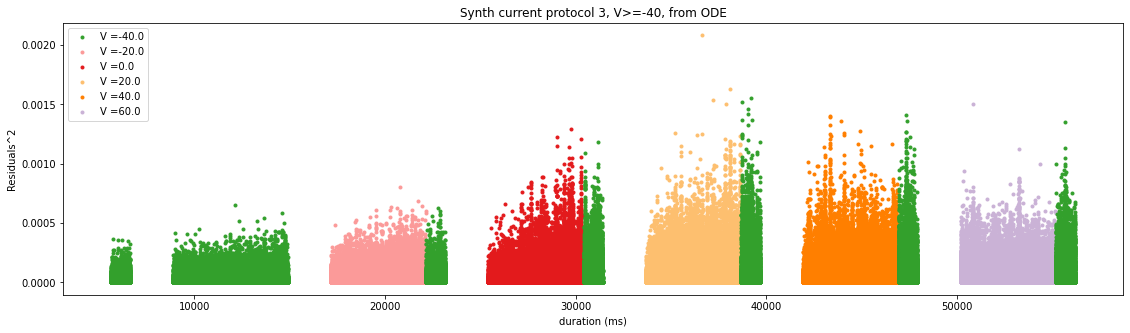

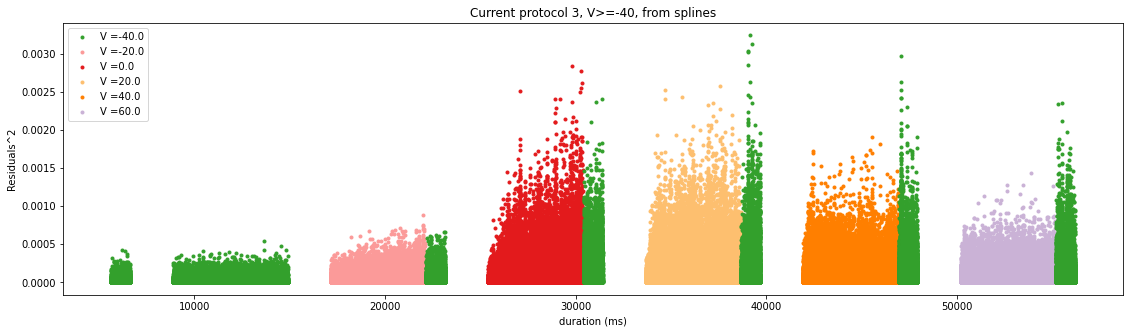

In [16]:
print('Calculating residuals for [real data vs splines] and [synth data vs ode]')

for index_i in range(len(index_largerCurrents)):
    i=index_largerCurrents[index_i] 
    residuals = synth_currents_largerCurrents[index_i] - ode_largerCurrents[index_i]
    ode_residuals2_largerCurrents[index_i] = residuals ** 2
    residuals = currents_largerCurrents[index_i] - splines_largerCurrents[index_i]
    splines_residuals2_largerCurrents[index_i] = residuals ** 2


plt.figure(figsize=(19, 5))
for index_i in range(len(index_largerCurrents)):
    i=index_largerCurrents[index_i] 
    plt.plot(times_largerCurrents[index_i], ode_residuals2_largerCurrents[index_i],'.', color = pr3_voltage_constV_colors[i], label=pr3_voltage_constV_labels_simple[i])
plt.xlabel('duration (ms)')
plt.ylabel('Residuals^2')
plt.title('Synth current protocol 3, V>=-40, from ODE')
plt.legend(loc='upper left')
plt.show()

plt.figure(figsize=(19, 5))
for index_i in range(len(index_largerCurrents)):
    i=index_largerCurrents[index_i] 
    plt.plot(times_largerCurrents[index_i], splines_residuals2_largerCurrents[index_i],'.', color = pr3_voltage_constV_colors[i], label=pr3_voltage_constV_labels_simple[i])
plt.xlabel('duration (ms)')
plt.ylabel('Residuals^2')
plt.title('Current protocol 3, V>=-40, from splines')
plt.legend(loc='upper left')
plt.show()

In [30]:
print('Bin by current')
# Take Batch_size time steps and take mean of the residuals, and mean of the spline fit to get a nicer plot
current_batch_size  = 0.1

print('Binning the real data')

splines_times_largerCurrents_bycurrent = [None] * len(index_largerCurrents)
current_SORTindex_splines = [None] * len(index_largerCurrents)

currents_largerCurrents_bycurrent = [None] * len(index_largerCurrents)
currents_largerCurrents_bycurrent_meanbatch = [None] * len(index_largerCurrents)
currents_largerCurrents_bycurrent_stdbatch = [None] * len(index_largerCurrents)

splines_largerCurrents_bycurrent = [None] * len(index_largerCurrents)
splines_largerCurrents_bycurrent_meanbatch = [None] * len(index_largerCurrents)
splines_largerCurrents_bycurrent_stdbatch = [None] * len(index_largerCurrents)

splines_residuals2_largerCurrents_bycurrent = [None] * len(index_largerCurrents)
splines_residuals2_largerCurrents_bycurrent_meanbatch = [None] * len(index_largerCurrents)
splines_residuals2_largerCurrents_bycurrent_stdbatch = [None] * len(index_largerCurrents)



for index_i in range(len(index_largerCurrents)):
    # find the index to surt the current
    current_SORTindex_splines[index_i] = np.argsort(splines_largerCurrents[index_i])
    # arrange the vectors by current sort
    currents_largerCurrents_bycurrent[index_i] = currents_largerCurrents[index_i][current_SORTindex_splines[index_i]]
    splines_times_largerCurrents_bycurrent[index_i] = times_largerCurrents[index_i][current_SORTindex_splines[index_i]]
    splines_residuals2_largerCurrents_bycurrent[index_i] = splines_residuals2_largerCurrents[index_i][current_SORTindex_splines[index_i]]
    splines_largerCurrents_bycurrent[index_i] = splines_largerCurrents[index_i][current_SORTindex_splines[index_i]]
    # BATCHING:
    current_batches = np.arange(splines_largerCurrents_bycurrent[index_i][0],splines_largerCurrents_bycurrent[index_i][-1],current_batch_size)
    last_current_in_batch = np.zeros(len(current_batches)+1).astype(int)
    splines_residuals2_largerCurrents_bycurrent_meanbatch[index_i] = np.zeros(len(current_batches))
    splines_largerCurrents_bycurrent_meanbatch[index_i] = np.zeros(len(current_batches))
    currents_largerCurrents_bycurrent_meanbatch[index_i] = np.zeros(len(current_batches))
    splines_residuals2_largerCurrents_bycurrent_stdbatch[index_i] = np.zeros(len(current_batches))
    splines_largerCurrents_bycurrent_stdbatch[index_i] = np.zeros(len(current_batches))
    currents_largerCurrents_bycurrent_stdbatch[index_i] = np.zeros(len(current_batches))
    empty_batches =[]
    for i in range(len(current_batches)):
        # deal with the last interval
        if i == len(current_batches)-1:
            last_current_in_batch[i+1] = len(splines_largerCurrents_bycurrent[index_i])-1
        else:
            last_current_in_batch[i+1] = np.argmax(splines_largerCurrents_bycurrent[index_i]>current_batches[i+1])

        # dealing with the especial cases
        if last_current_in_batch[i+1] == last_current_in_batch[i]:
            # in case there is no point in that interval
            # save the index to remove it at the end
            empty_batches.extend([i])        
        elif last_current_in_batch[i+1]  == last_current_in_batch[i]+1:
            # in case there is onely one point in that interval
            # save the index to remove it at the end
            empty_batches.extend([i])
        else:
            splines_residuals2_largerCurrents_bycurrent_meanbatch[index_i][i] = np.mean(splines_residuals2_largerCurrents_bycurrent[index_i][last_current_in_batch[i]:last_current_in_batch[i+1]-1])
            splines_largerCurrents_bycurrent_meanbatch[index_i][i] = np.mean(splines_largerCurrents_bycurrent[index_i][last_current_in_batch[i]:last_current_in_batch[i+1]-1])
            currents_largerCurrents_bycurrent_meanbatch[index_i][i] = np.mean(currents_largerCurrents_bycurrent[index_i][last_current_in_batch[i]:last_current_in_batch[i+1]-1])
            splines_residuals2_largerCurrents_bycurrent_stdbatch[index_i][i] = np.std(splines_residuals2_largerCurrents_bycurrent[index_i][last_current_in_batch[i]:last_current_in_batch[i+1]-1])
            splines_largerCurrents_bycurrent_stdbatch[index_i][i] = np.std(splines_largerCurrents_bycurrent[index_i][last_current_in_batch[i]:last_current_in_batch[i+1]-1])
            currents_largerCurrents_bycurrent_stdbatch[index_i][i] = np.std(currents_largerCurrents_bycurrent[index_i][last_current_in_batch[i]:last_current_in_batch[i+1]-1])
    if len(empty_batches)>0:
        print([index_i, np.shape(splines_residuals2_largerCurrents_bycurrent_stdbatch[index_i]),len(empty_batches)])
        splines_residuals2_largerCurrents_bycurrent_meanbatch[index_i] = np.delete(splines_residuals2_largerCurrents_bycurrent_meanbatch[index_i],empty_batches)
        splines_largerCurrents_bycurrent_meanbatch[index_i] = np.delete(splines_largerCurrents_bycurrent_meanbatch[index_i], empty_batches)
        currents_largerCurrents_bycurrent_meanbatch[index_i] = np.delete(currents_largerCurrents_bycurrent_meanbatch[index_i],empty_batches)
        splines_residuals2_largerCurrents_bycurrent_stdbatch[index_i] = np.delete(splines_residuals2_largerCurrents_bycurrent_stdbatch[index_i], empty_batches)
        splines_largerCurrents_bycurrent_stdbatch[index_i] = np.delete(splines_largerCurrents_bycurrent_stdbatch[index_i],empty_batches)
        currents_largerCurrents_bycurrent_stdbatch[index_i] = np.delete(currents_largerCurrents_bycurrent_stdbatch[index_i],empty_batches)

Bin by current
Binning the real data


In [31]:
print('Binning the synth data')


ode_times_largerCurrents_bycurrent = [None] * len(index_largerCurrents)
current_SORTindex_ode = [None] * len(index_largerCurrents)

synth_currents_largerCurrents_bycurrent = [None] * len(index_largerCurrents)
synth_currents_largerCurrents_bycurrent_meanbatch = [None] * len(index_largerCurrents)
synth_currents_largerCurrents_bycurrent_stdbatch = [None] * len(index_largerCurrents)

ode_largerCurrents_bycurrent = [None] * len(index_largerCurrents)
ode_largerCurrents_bycurrent_meanbatch = [None] * len(index_largerCurrents)
ode_largerCurrents_bycurrent_stdbatch = [None] * len(index_largerCurrents)

ode_residuals2_largerCurrents_bycurrent = [None] * len(index_largerCurrents)
ode_residuals2_largerCurrents_bycurrent_meanbatch = [None] * len(index_largerCurrents)
ode_residuals2_largerCurrents_bycurrent_stdbatch = [None] * len(index_largerCurrents)



for index_i in range(len(index_largerCurrents)):
    # find the index to surt the current
    current_SORTindex_ode[index_i] = np.argsort(ode_largerCurrents[index_i])
    # arrange the vectors by current sort
    synth_currents_largerCurrents_bycurrent[index_i] = synth_currents_largerCurrents[index_i][current_SORTindex_ode[index_i]]
    ode_times_largerCurrents_bycurrent[index_i] = times_largerCurrents[index_i][current_SORTindex_ode[index_i]]
    ode_residuals2_largerCurrents_bycurrent[index_i] = ode_residuals2_largerCurrents[index_i][current_SORTindex_ode[index_i]]
    ode_largerCurrents_bycurrent[index_i] = ode_largerCurrents[index_i][current_SORTindex_ode[index_i]]
    # BATCHING:
    current_batches = np.arange(ode_largerCurrents_bycurrent[index_i][0],ode_largerCurrents_bycurrent[index_i][-1],current_batch_size)
    last_current_in_batch = np.zeros(len(current_batches)+1).astype(int)
    ode_residuals2_largerCurrents_bycurrent_meanbatch[index_i] = np.zeros(len(current_batches))
    ode_largerCurrents_bycurrent_meanbatch[index_i] = np.zeros(len(current_batches))
    synth_currents_largerCurrents_bycurrent_meanbatch[index_i] = np.zeros(len(current_batches))
    ode_residuals2_largerCurrents_bycurrent_stdbatch[index_i] = np.zeros(len(current_batches))
    ode_largerCurrents_bycurrent_stdbatch[index_i] = np.zeros(len(current_batches))
    synth_currents_largerCurrents_bycurrent_stdbatch[index_i] = np.zeros(len(current_batches))
    empty_batches =[]
    for i in range(len(current_batches)):
        # deal with the last interval
        if i == len(current_batches)-1:
            last_current_in_batch[i+1] = len(ode_largerCurrents_bycurrent[index_i])-1
        else:
            last_current_in_batch[i+1] = np.argmax(ode_largerCurrents_bycurrent[index_i]>current_batches[i+1])

        # dealing with the especial cases
        if last_current_in_batch[i+1] == last_current_in_batch[i]:
            # in case there is no point in that interval
            # save the index to remove it at the end
            empty_batches.extend([i])        
        elif last_current_in_batch[i+1]  == last_current_in_batch[i]+1:
            # in case there is onely one point in that interval
            # save the index to remove it at the end
            empty_batches.extend([i])
        else:
            ode_residuals2_largerCurrents_bycurrent_meanbatch[index_i][i] = np.mean(ode_residuals2_largerCurrents_bycurrent[index_i][last_current_in_batch[i]:last_current_in_batch[i+1]-1])
            ode_largerCurrents_bycurrent_meanbatch[index_i][i] = np.mean(ode_largerCurrents_bycurrent[index_i][last_current_in_batch[i]:last_current_in_batch[i+1]-1])
            synth_currents_largerCurrents_bycurrent_meanbatch[index_i][i] = np.mean(synth_currents_largerCurrents_bycurrent[index_i][last_current_in_batch[i]:last_current_in_batch[i+1]-1])
            ode_residuals2_largerCurrents_bycurrent_stdbatch[index_i][i] = np.std(ode_residuals2_largerCurrents_bycurrent[index_i][last_current_in_batch[i]:last_current_in_batch[i+1]-1])
            ode_largerCurrents_bycurrent_stdbatch[index_i][i] = np.std(ode_largerCurrents_bycurrent[index_i][last_current_in_batch[i]:last_current_in_batch[i+1]-1])
            synth_currents_largerCurrents_bycurrent_stdbatch[index_i][i] = np.std(synth_currents_largerCurrents_bycurrent[index_i][last_current_in_batch[i]:last_current_in_batch[i+1]-1])
    if len(empty_batches)>0:
        print([index_i, np.shape(ode_residuals2_largerCurrents_bycurrent_stdbatch[index_i]),len(empty_batches)])
        ode_residuals2_largerCurrents_bycurrent_meanbatch[index_i] = np.delete(ode_residuals2_largerCurrents_bycurrent_meanbatch[index_i],empty_batches)
        ode_largerCurrents_bycurrent_meanbatch[index_i] = np.delete(ode_largerCurrents_bycurrent_meanbatch[index_i], empty_batches)
        synth_currents_largerCurrents_bycurrent_meanbatch[index_i] = np.delete(synth_currents_largerCurrents_bycurrent_meanbatch[index_i],empty_batches)
        ode_residuals2_largerCurrents_bycurrent_stdbatch[index_i] = np.delete(ode_residuals2_largerCurrents_bycurrent_stdbatch[index_i], empty_batches)
        ode_largerCurrents_bycurrent_stdbatch[index_i] = np.delete(ode_largerCurrents_bycurrent_stdbatch[index_i],empty_batches)
        synth_currents_largerCurrents_bycurrent_stdbatch[index_i] = np.delete(synth_currents_largerCurrents_bycurrent_stdbatch[index_i],empty_batches)

Binning the synth data


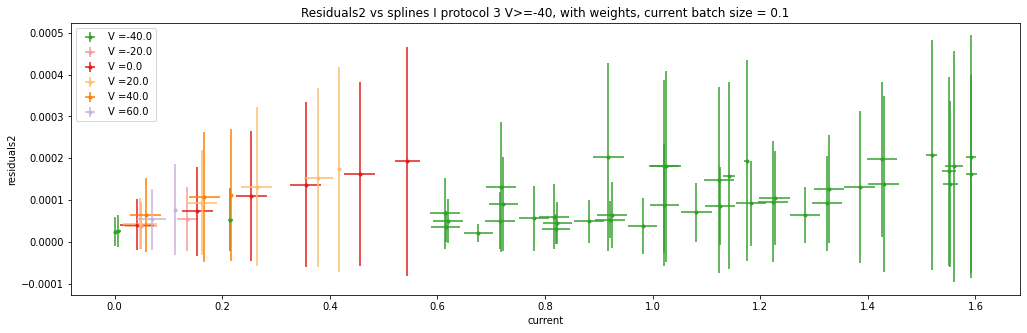

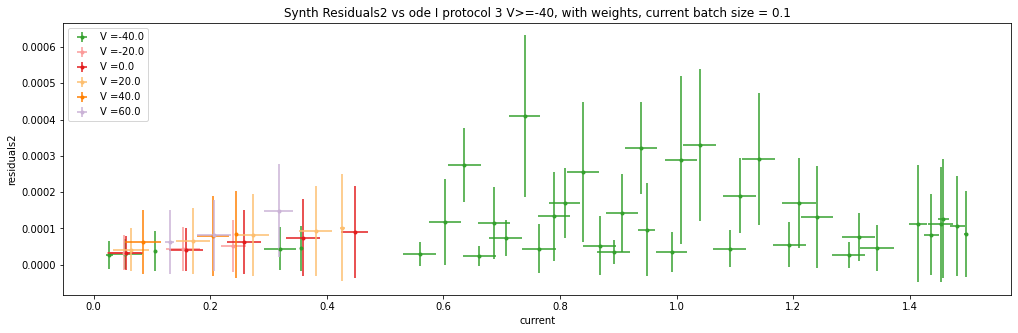

In [32]:
plt.figure(figsize=(17, 5))
for index_i in range(len(index_largerCurrents)):
    i=index_largerCurrents[index_i] 
    plt.errorbar(splines_largerCurrents_bycurrent_meanbatch[index_i],splines_residuals2_largerCurrents_bycurrent_meanbatch[index_i],xerr=splines_largerCurrents_bycurrent_stdbatch[index_i], yerr=splines_residuals2_largerCurrents_bycurrent_stdbatch[index_i], fmt='.',color = pr3_voltage_constV_colors[i], label = pr3_voltage_constV_labels_simple[i] )
    plt.xlabel('current')
    plt.ylabel('residuals2')
    plt.title('Residuals2 vs splines I protocol 3 V>=-40, with weights, current batch size = '+ str(current_batch_size))
    plt.legend(loc='upper left')
plt.show()


plt.figure(figsize=(17, 5))
for index_i in range(len(index_largerCurrents)):
    i=index_largerCurrents[index_i] 
    plt.errorbar(ode_largerCurrents_bycurrent_meanbatch[index_i], ode_residuals2_largerCurrents_bycurrent_meanbatch[index_i], xerr=ode_largerCurrents_bycurrent_stdbatch[index_i], yerr=ode_residuals2_largerCurrents_bycurrent_stdbatch[index_i], fmt='.',color = pr3_voltage_constV_colors[i], label = pr3_voltage_constV_labels_simple[i] )
    plt.xlabel('current')
    plt.ylabel('residuals2')
    plt.title('Synth Residuals2 vs ode I protocol 3 V>=-40, with weights, current batch size = '+ str(current_batch_size))
    plt.legend(loc='upper left')
plt.show()

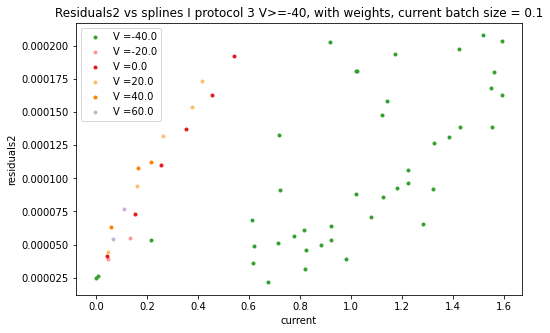

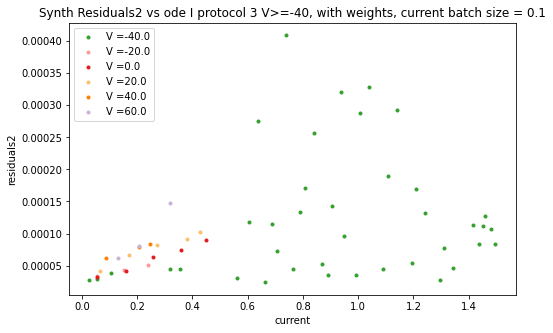

In [36]:
plt.figure(figsize=(8, 5))
for index_i in range(len(index_largerCurrents)):
    i=index_largerCurrents[index_i] 
    plt.plot(splines_largerCurrents_bycurrent_meanbatch[index_i],splines_residuals2_largerCurrents_bycurrent_meanbatch[index_i],'.',color = pr3_voltage_constV_colors[i], label = pr3_voltage_constV_labels_simple[i] )
    plt.xlabel('current')
    plt.ylabel('residuals2')
    plt.title('Residuals2 vs splines I protocol 3 V>=-40, with weights, current batch size = '+ str(current_batch_size))
    plt.legend(loc='upper left')
plt.show()


plt.figure(figsize=(8, 5))
for index_i in range(len(index_largerCurrents)):
    i=index_largerCurrents[index_i] 
    plt.plot(ode_largerCurrents_bycurrent_meanbatch[index_i], ode_residuals2_largerCurrents_bycurrent_meanbatch[index_i], '.',color = pr3_voltage_constV_colors[i], label = pr3_voltage_constV_labels_simple[i] )
    plt.xlabel('current')
    plt.ylabel('residuals2')
    plt.title('Synth Residuals2 vs ode I protocol 3 V>=-40, with weights, current batch size = '+ str(current_batch_size))
    plt.legend(loc='upper left')
plt.show()






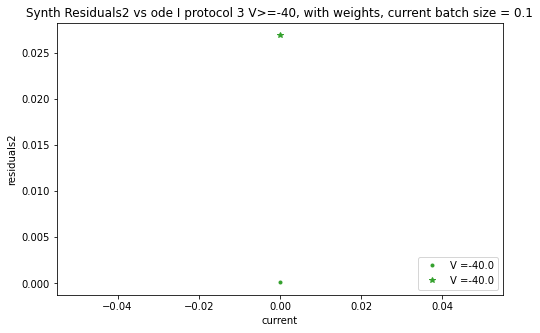

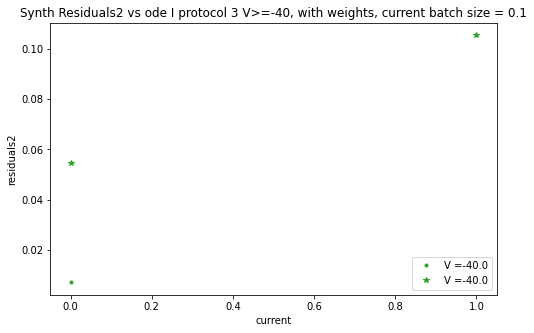

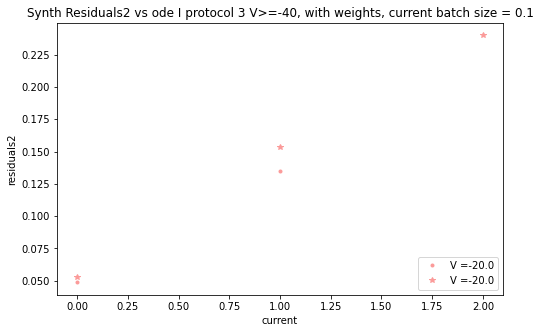

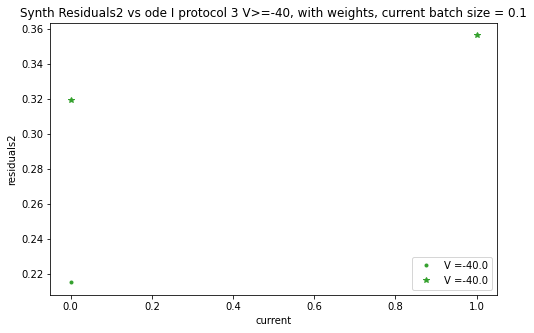

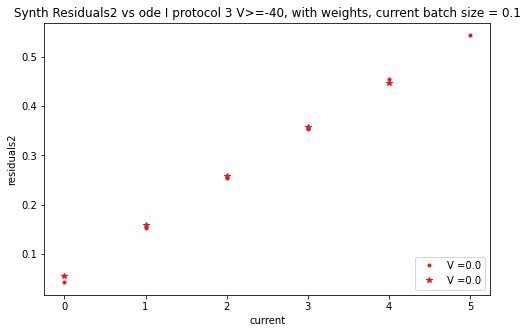

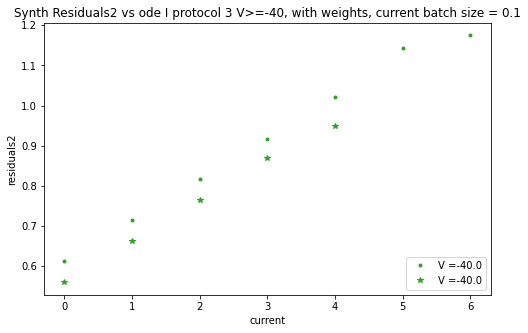

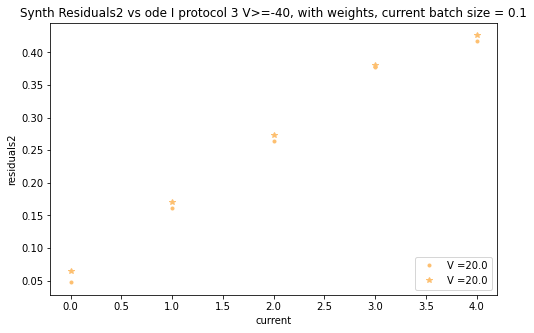

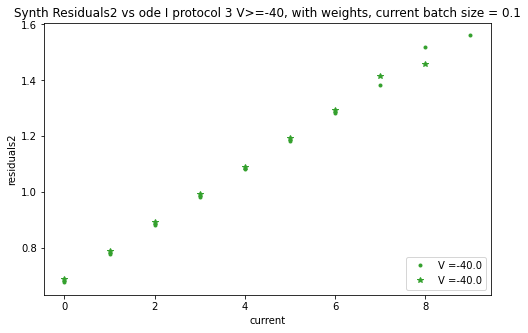

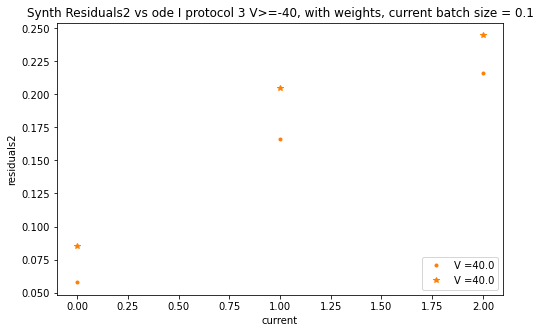

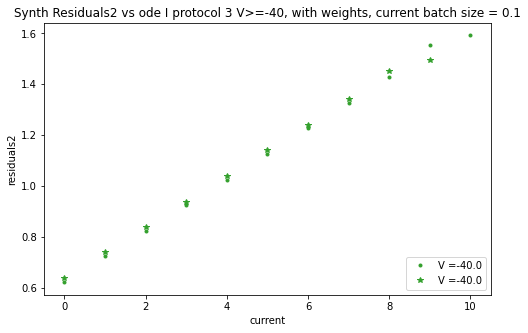

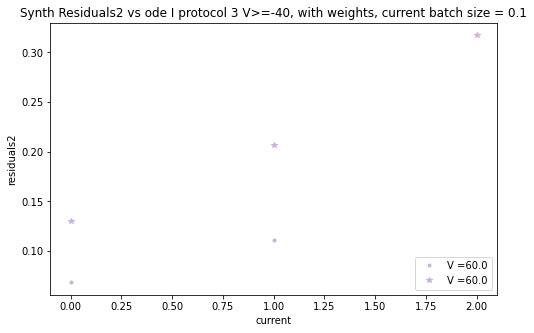

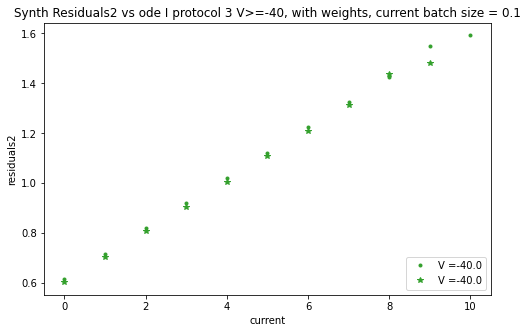

In [42]:


for index_i in range(len(index_largerCurrents)):
    plt.figure(figsize=(8, 5))
    i=index_largerCurrents[index_i] 
    plt.plot(splines_largerCurrents_bycurrent_meanbatch[index_i],'.',color = pr3_voltage_constV_colors[i], label = pr3_voltage_constV_labels_full[i] )
    plt.plot(ode_largerCurrents_bycurrent_meanbatch[index_i], '*',color = pr3_voltage_constV_colors[i], label = pr3_voltage_constV_labels_full[i] )
    plt.xlabel('current')
    plt.ylabel('residuals2')
    plt.title('Synth Residuals2 vs ode I protocol 3 V>=-40, with weights, current batch size = '+ str(current_batch_size))
    plt.legend(loc='lower right')
plt.show()

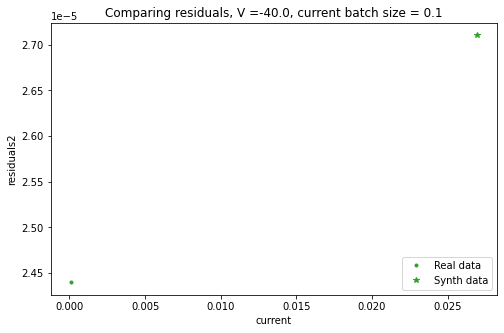

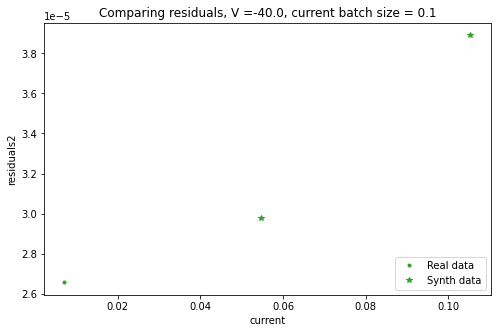

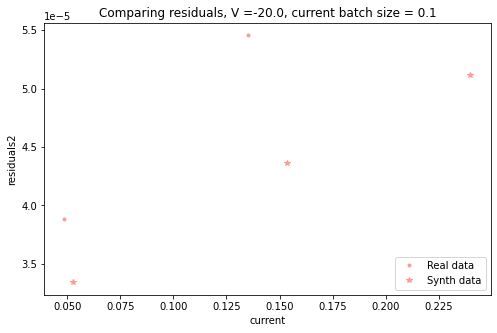

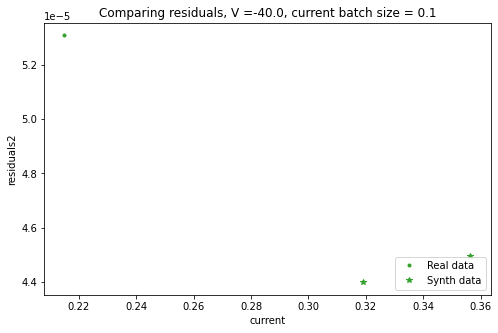

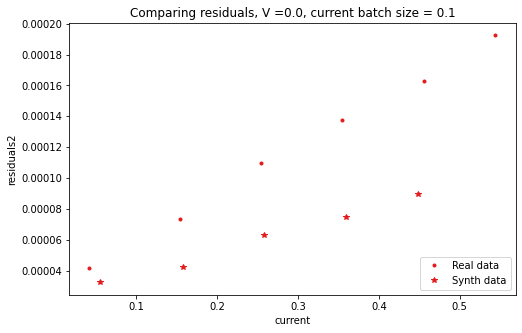

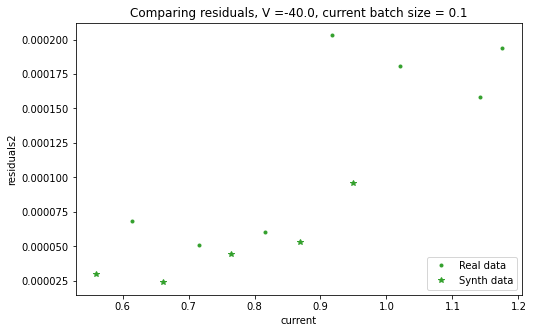

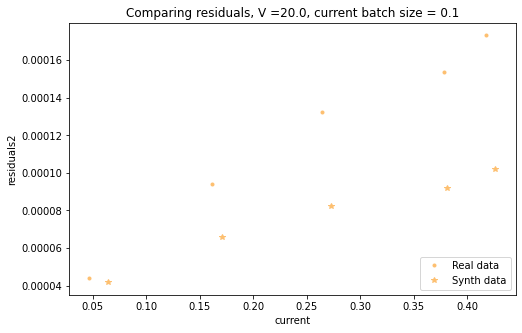

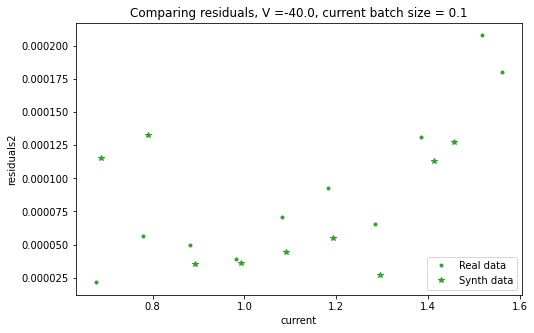

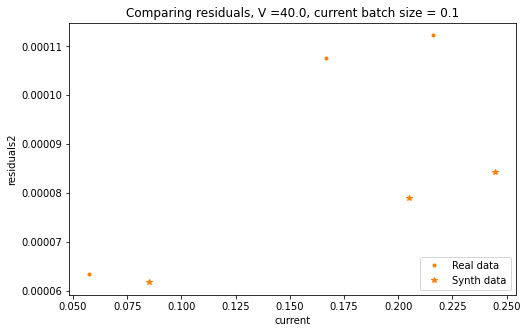

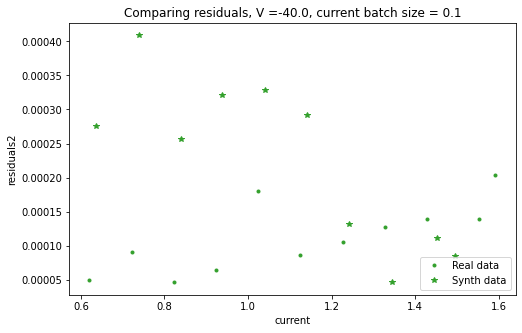

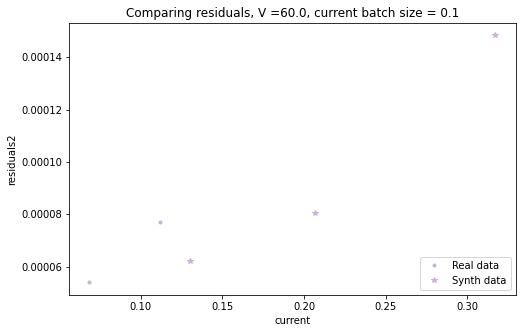

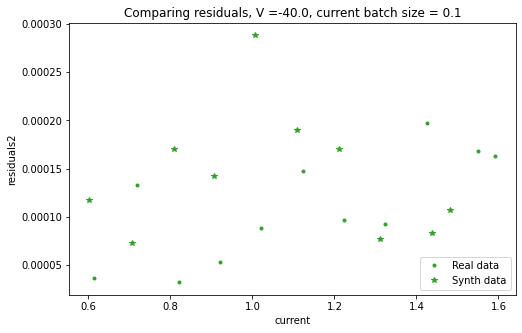

In [51]:
for index_i in range(len(index_largerCurrents)):
    plt.figure(figsize=(8, 5))
    i=index_largerCurrents[index_i] 
    plt.plot(splines_largerCurrents_bycurrent_meanbatch[index_i], splines_residuals2_largerCurrents_bycurrent_meanbatch[index_i],'.',color = pr3_voltage_constV_colors[i], label = 'Real data' )
    plt.plot(ode_largerCurrents_bycurrent_meanbatch[index_i],ode_residuals2_largerCurrents_bycurrent_meanbatch[index_i], '*',color = pr3_voltage_constV_colors[i], label = 'Synth data' )
    plt.xlabel('current')
    plt.ylabel('residuals2')
    plt.title('Comparing residuals, ' + pr3_voltage_constV_labels_full[i] + ', current batch size = '+ str(current_batch_size))
    plt.legend(loc='lower right')
plt.show()

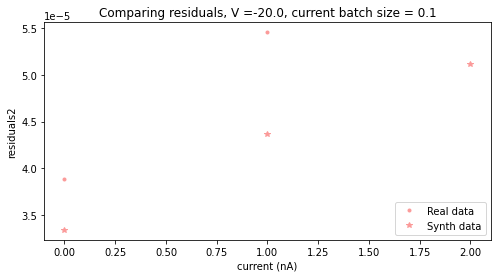

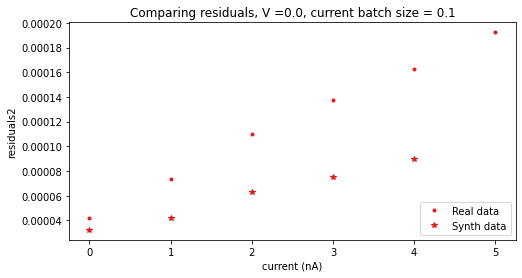

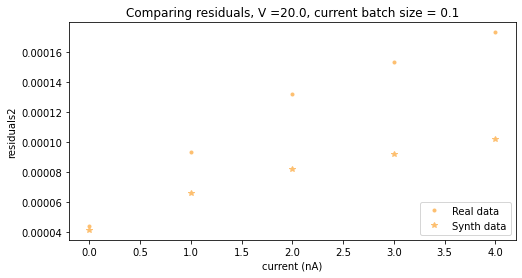

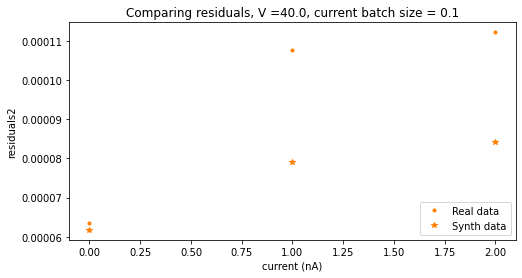

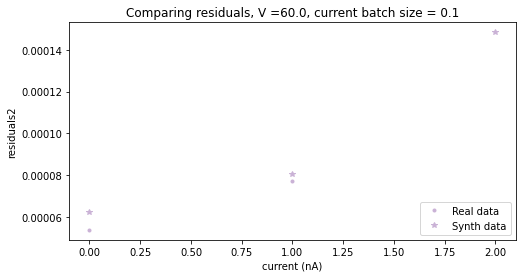

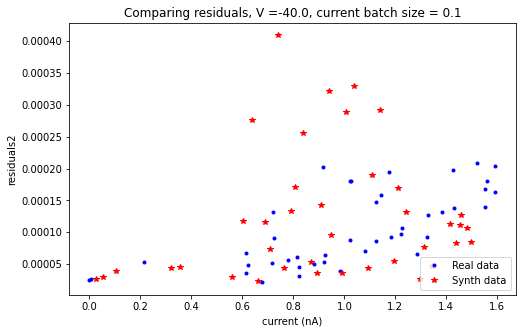

In [50]:
for index_i in range(len(index_largerCurrents)):
    i=index_largerCurrents[index_i] 
    if pr3_voltage_constV[i] != -40:
        plt.figure(figsize=(8, 4)) 
        plt.plot(splines_residuals2_largerCurrents_bycurrent_meanbatch[index_i],'.',color = pr3_voltage_constV_colors[i], label = 'Real data' )
        plt.plot(ode_residuals2_largerCurrents_bycurrent_meanbatch[index_i], '*',color = pr3_voltage_constV_colors[i], label = 'Synth data' )
        plt.xlabel('current (nA)')
        plt.ylabel('residuals2')
        plt.title('Comparing residuals, ' + pr3_voltage_constV_labels_full[i] + ', current batch size = '+ str(current_batch_size))
        plt.legend(loc='lower right')
plt.show()

plt.figure(figsize=(8, 5))
for index_i in range(len(index_largerCurrents)):
    i=index_largerCurrents[index_i] 
    if pr3_voltage_constV[i] == -40:
        if index_i==0:
            plt.plot(splines_largerCurrents_bycurrent_meanbatch[index_i],splines_residuals2_largerCurrents_bycurrent_meanbatch[index_i],'b.', label = 'Real data' )
            plt.plot(ode_largerCurrents_bycurrent_meanbatch[index_i],ode_residuals2_largerCurrents_bycurrent_meanbatch[index_i], 'r*', label = 'Synth data' )
        else:
            plt.plot(splines_largerCurrents_bycurrent_meanbatch[index_i],splines_residuals2_largerCurrents_bycurrent_meanbatch[index_i],'b.', label = '_nolegend_' )
            plt.plot(ode_largerCurrents_bycurrent_meanbatch[index_i], ode_residuals2_largerCurrents_bycurrent_meanbatch[index_i], 'r*', label = '_nolegend_' )
       
        plt.xlabel('current (nA)')
        plt.ylabel('residuals2')
        plt.title('Comparing residuals, ' + pr3_voltage_constV_labels_full[i] + ', current batch size = '+ str(current_batch_size))
        plt.legend(loc='lower right')
plt.show()

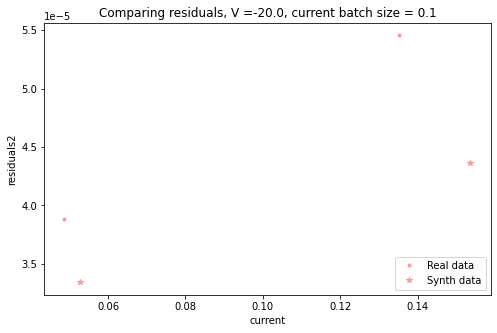

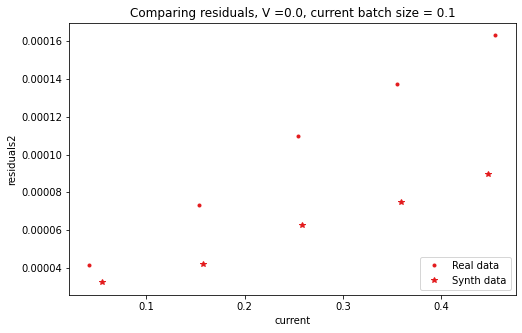

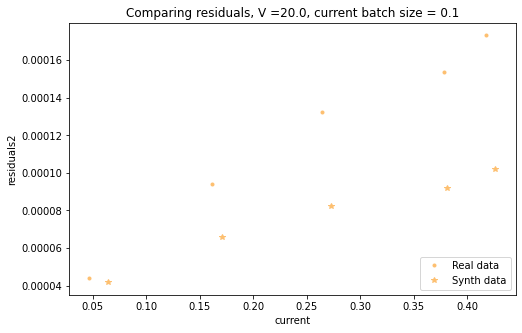

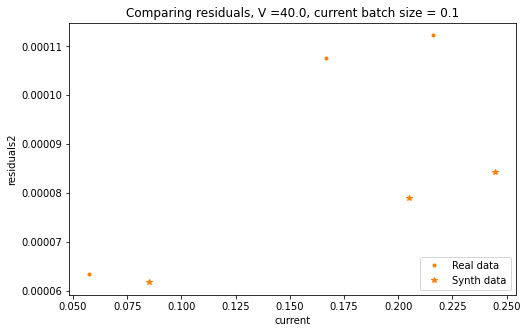

In [61]:
index_mathching_binning = [2,4,6,8]
for index_i in index_mathching_binning:
    plt.figure(figsize=(8, 5))
    i=index_largerCurrents[index_i] 
    if pr3_voltage_constV[i]==0:
        plt.plot(splines_largerCurrents_bycurrent_meanbatch[index_i][:-1], splines_residuals2_largerCurrents_bycurrent_meanbatch[index_i][:-1],'.',color = pr3_voltage_constV_colors[i], label = 'Real data' )
        plt.plot(ode_largerCurrents_bycurrent_meanbatch[index_i],ode_residuals2_largerCurrents_bycurrent_meanbatch[index_i], '*',color = pr3_voltage_constV_colors[i], label = 'Synth data' )
    elif pr3_voltage_constV[i]==-20:
        plt.plot(splines_largerCurrents_bycurrent_meanbatch[index_i], splines_residuals2_largerCurrents_bycurrent_meanbatch[index_i],'.',color = pr3_voltage_constV_colors[i], label = 'Real data' )
        plt.plot(ode_largerCurrents_bycurrent_meanbatch[index_i][:-1],ode_residuals2_largerCurrents_bycurrent_meanbatch[index_i][:-1], '*',color = pr3_voltage_constV_colors[i], label = 'Synth data' )
    else:
        plt.plot(splines_largerCurrents_bycurrent_meanbatch[index_i], splines_residuals2_largerCurrents_bycurrent_meanbatch[index_i],'.',color = pr3_voltage_constV_colors[i], label = 'Real data' )
        plt.plot(ode_largerCurrents_bycurrent_meanbatch[index_i],ode_residuals2_largerCurrents_bycurrent_meanbatch[index_i], '*',color = pr3_voltage_constV_colors[i], label = 'Synth data' )
    plt.xlabel('current')
    plt.ylabel('residuals2')
    plt.title('Comparing residuals, ' + pr3_voltage_constV_labels_full[i] + ', current batch size = '+ str(current_batch_size))
    plt.legend(loc='lower right')
plt.show()



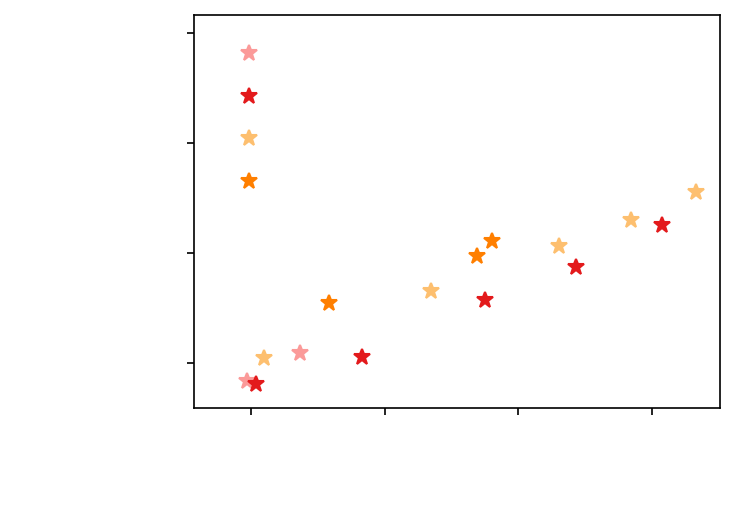

In [131]:
plt.figure(figsize=(5, 3.5), dpi = 150, tight_layout = True)

plt.plot(np.linspace(0.00003,0.00016),np.linspace(0.00003,0.00016),':', color = 'white',label='_nolegend_')
for index_i in index_mathching_binning:
    i=index_largerCurrents[index_i] 
    if pr3_voltage_constV[i]==0:
        plt.plot(splines_residuals2_largerCurrents_bycurrent_meanbatch[index_i][:-1], ode_residuals2_largerCurrents_bycurrent_meanbatch[index_i], '*', markersize = 8, color = pr3_voltage_constV_colors[i], label = pr3_voltage_constV_labels_full[i])
    elif pr3_voltage_constV[i]==-20:
        plt.plot(splines_residuals2_largerCurrents_bycurrent_meanbatch[index_i], ode_residuals2_largerCurrents_bycurrent_meanbatch[index_i][:-1], '*', markersize = 8, color = pr3_voltage_constV_colors[i], label = pr3_voltage_constV_labels_full[i])
    else:
        plt.plot(splines_residuals2_largerCurrents_bycurrent_meanbatch[index_i], ode_residuals2_largerCurrents_bycurrent_meanbatch[index_i], '*', markersize = 8, color = pr3_voltage_constV_colors[i], label = pr3_voltage_constV_labels_full[i] )
plt.ylabel('Var(sim)', fontsize=18, color = 'white')
plt.xlabel('Var(data)', fontsize=18, color = 'white')
#plt.title('Var estimates for  V in [-20,40]',fontsize=18, color = 'white')
plt.yticks([4e-5,8e-5,12e-5,16e-5],fontsize=14, color = 'white')
plt.xticks([4e-5,8e-5,12e-5,16e-5],fontsize=14, color = 'white')
plt.legend(loc='upper left', fontsize = 14, framealpha = 0, labelcolor='white')
plt.savefig('pr3_Var_data_Var_sim_plot.png', transparent = True, dpi = 300)
plt.show()

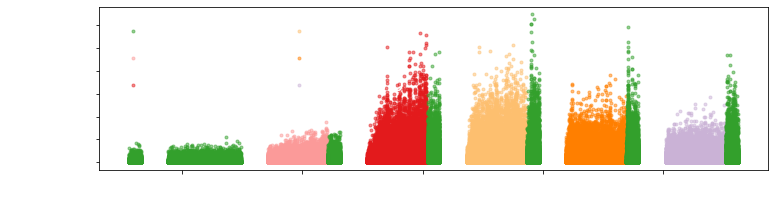

In [77]:
plt.figure(figsize=(12, 3))
for index_i in range(len(index_largerCurrents)):
    i=index_largerCurrents[index_i] 
    plt.plot(times_largerCurrents[index_i], splines_residuals2_largerCurrents[index_i],'.', alpha =0.5, color = pr3_voltage_constV_colors[i], label=pr3_voltage_constV_labels_simple[i])
plt.xlabel('time(ms)', fontsize=18, color = 'white')
plt.ylabel('residuals^2', fontsize=18, color = 'white')
plt.yticks(fontsize=18, color = 'white')
plt.xticks(fontsize=18, color = 'white')
plt.legend(loc='upper left', ncol =2, fontsize = 18, framealpha = 0, labelcolor='white')
plt.savefig('pr3_largecurrents_residuals_plot.png', transparent = True, dpi = 300)
plt.show()




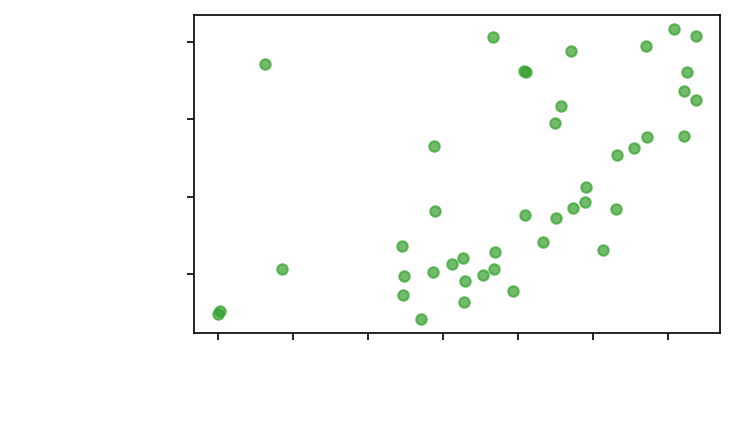

In [106]:
plt.figure(figsize=(5, 3),dpi = 150, tight_layout = True)
for index_i in range(len(index_largerCurrents)):
    i=index_largerCurrents[index_i] 
    if pr3_voltage_constV[i] == -40:
        #plt.errorbar(splines_largerCurrents_bycurrent_meanbatch[index_i], splines_residuals2_largerCurrents_bycurrent_meanbatch[index_i], yerr=splines_residuals2_largerCurrents_bycurrent_stdbatch[index_i], fmt='.',color = pr3_voltage_constV_colors[i], label = pr3_voltage_constV_labels_simple[i] )
        plt.plot(splines_largerCurrents_bycurrent_meanbatch[index_i], splines_residuals2_largerCurrents_bycurrent_meanbatch[index_i], '.', markersize = 10, alpha = 0.7, color = pr3_voltage_constV_colors[i], label = pr3_voltage_constV_labels_simple[i] )
plt.xlabel('current (nA)', fontsize = 18,  color = 'white')
plt.ylabel('var',fontsize = 18,   color = 'white')
plt.yticks( color = 'white', fontsize = 14)
plt.xticks( color = 'white', fontsize = 14)
plt.legend(loc='upper left', ncol =2,fontsize = 18,   framealpha = 0, labelcolor='white')
plt.savefig('pr3_largecurrents_residuals_V40_plot.png', transparent = True, dpi = 150)
plt.show()


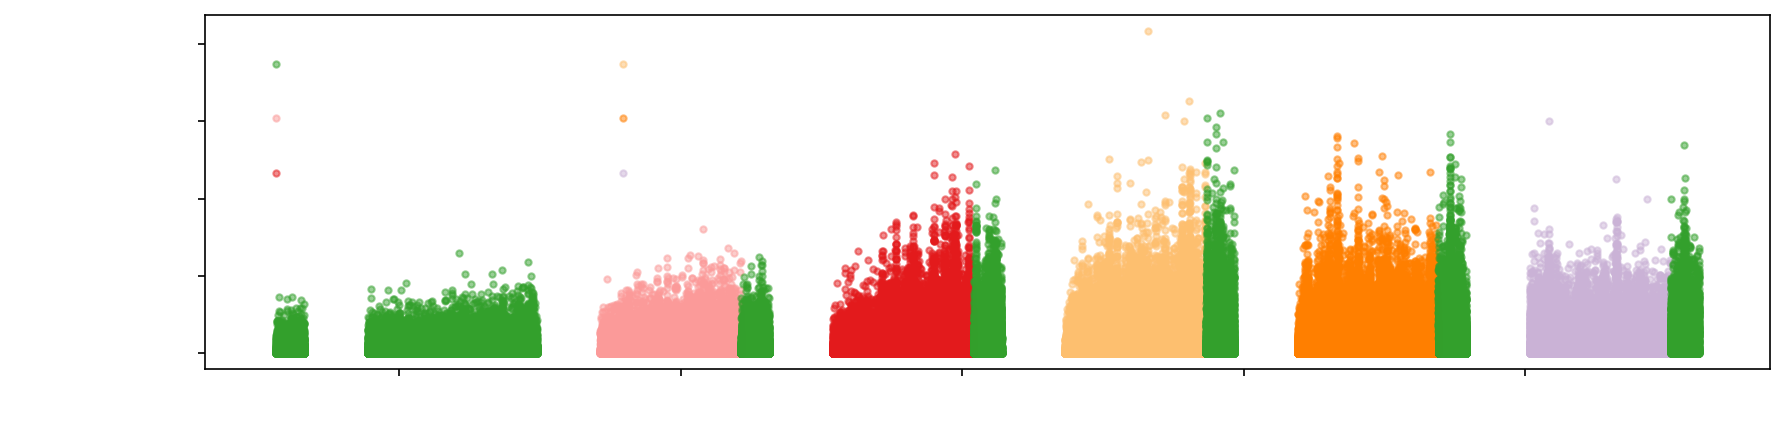

In [102]:
plt.figure(figsize=(12, 3),dpi = 150, tight_layout = True)
for index_i in range(len(index_largerCurrents)):
    i=index_largerCurrents[index_i] 
    plt.plot(times_largerCurrents[index_i], ode_residuals2_largerCurrents[index_i],'.', alpha =0.5, color = pr3_voltage_constV_colors[i], label=pr3_voltage_constV_labels_simple[i])
#plt.xlabel('time(ms)', fontsize=18, color = 'white')
plt.ylabel('residuals^2', fontsize=18, color = 'white')
plt.yticks(fontsize=18, color = 'white')
plt.xticks(fontsize=18, color = 'white')
plt.legend(loc='upper left', ncol =2, fontsize = 18, framealpha = 0, labelcolor='white')
plt.savefig('pr3_largecurrents_residuals_SYNTH_plot.png', transparent = True, dpi = 300)
plt.show()


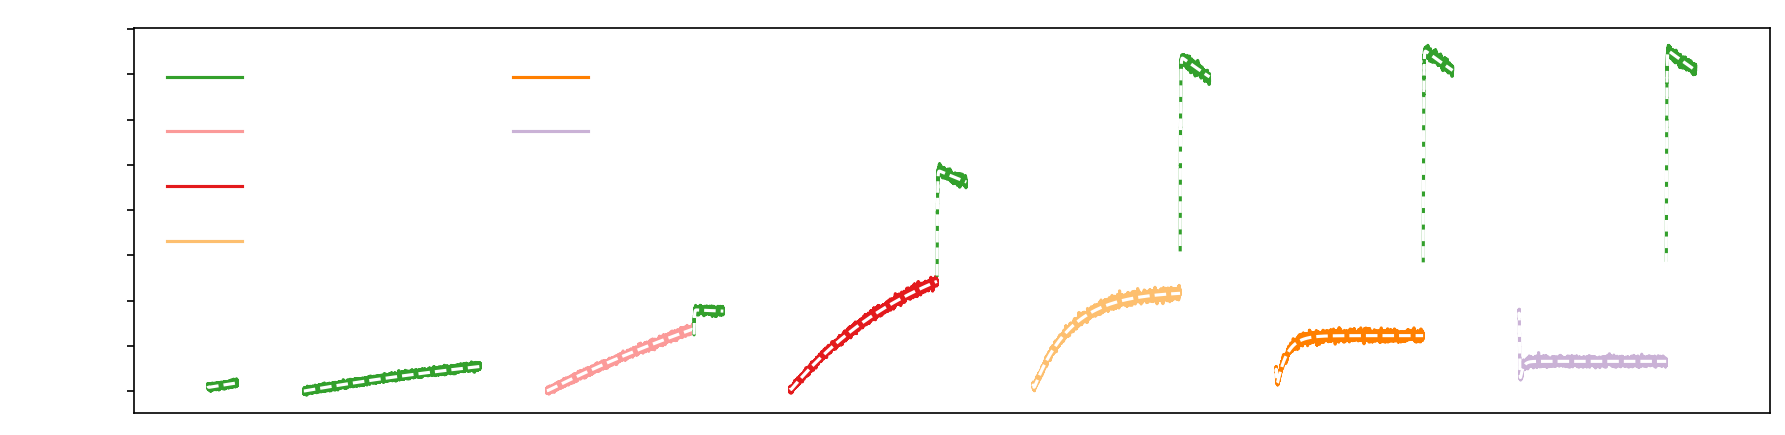

In [114]:
plt.figure(figsize=(12, 3),dpi = 150, tight_layout = True)

for index_i in range(len(index_largerCurrents)):
    i=index_largerCurrents[index_i] 
    plt.plot(times_largerCurrents[index_i], synth_currents_largerCurrents[index_i],'-', color = pr3_voltage_constV_colors[i], label=pr3_voltage_constV_labels_simple[i])
    if index_i == len(index_largerCurrents) - 1:
        plt.plot(times_largerCurrents[index_i], ode_largerCurrents[index_i],'--', color = 'white', label='ODE')
    else:
        plt.plot(times_largerCurrents[index_i], ode_largerCurrents[index_i],'--', color = 'white', label='_nolegend_')
#plt.xlabel('time(ms)', fontsize=18, color = 'white')
plt.ylabel('current (nA)', fontsize=18, color = 'white')
plt.yticks(fontsize=18, color = 'white')
plt.xticks([])#(fontsize=18, color = 'white')
plt.legend(loc='upper left', ncol =2, fontsize = 18, framealpha = 0, labelcolor='white')
plt.savefig('pr3_largecurrents_SYNTH_plot.png', transparent = True, dpi = 300)
plt.show()